# **Data Understanding**

There are sales data available for 45 stores of Walmart. This is the data that covers sales from 2010-02-05 to 2012-11-01.

**The data contains these features:**

> Store - the store number

> Date - the week of sales

> Weekly_Sales - sales for the given store

> Holiday_Flag - whether the week is a special holiday week 1 – Holiday  week 0 – Non-holiday week

> Temperature - Temperature on the day of sale

> Fuel_Price - Cost of fuel in the region

> CPI – Prevailing consumer price index

> Unemployment - Prevailing unemployment rate

In [49]:
import warnings
warnings.filterwarnings("ignore")

# **Installing Libraries**

In [50]:
!pip install pymc3==3.11.1

In [51]:
!pip install theano-pymc==1.1.2

# **Importing Libraries**

In [52]:
import numpy as np
import pandas as pd
from matplotlib import dates
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
#import pandas_profiling as pp
import seaborn as sns
sns.set()
from pymc3 import fit
from pymc3 import Model, Uniform ,Exponential,Normal
RANDOM_SEED = 20090425


# **Dataset**

In [53]:
# Load dataset
data = pd.read_csv('/content/SALES_DATA.csv')
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [54]:

# checking for missing values
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [55]:
sns.set(style="white")

corr = data.corr()

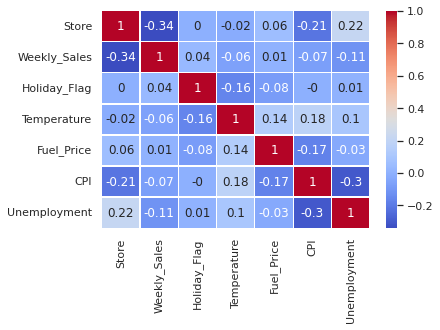

In [56]:
sns.heatmap(corr.round(2),linewidths=0.25,annot=True,cmap='coolwarm')

In [57]:
import datetime as dt 
data['Date'] =  pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [58]:
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month

In [59]:
data['quarter'] = data.Date.dt.quarter

# **Which store/s has good quarterly growth rate in Q3’2012?**

In [60]:
data1 = data.loc[data['quarter']== 2].loc[data['year'] == 2012].groupby(['quarter', 'Store']).sum('Weekly_Sales').reset_index().rename(columns={'Weekly_Sales':'Q2_sales'})
data1.head(5)

,quarter,Store,Q2_sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month
0,2,1,20978760.12,0,969.23,47.079,2881.918674,92.859,26156,66
1,2,2,25083604.88,0,974.45,47.079,2877.212466,89.583,26156,66
2,2,3,5620316.49,0,1013.92,47.079,2927.488384,86.632,26156,66
3,2,4,28454363.67,0,977.45,46.896,1703.025582,56.004,26156,66
4,2,5,4466363.69,0,986.51,47.079,2889.552775,75.413,26156,66


In [61]:
data2 = data.loc[data['quarter']== 3].loc[data['year'] == 2012].groupby(['quarter', 'Store'])['Weekly_Sales'].sum().reset_index().rename(columns={'Weekly_Sales':'Q3_sales'})
data2.head(15)

,quarter,Store,Q3_sales
0,3,1,20253947.78
1,3,2,24303354.86
2,3,3,5298005.47
3,3,4,27796792.46
4,3,5,4163790.99
5,3,6,20167312.24
6,3,7,8262787.39
7,3,8,11748952.70
8,3,9,7022149.56
9,3,10,23037258.76


In [62]:
data2 = data.loc[data['quarter']== 3].loc[data['year'] == 2012].groupby(['quarter', 'Store']).sum('Weekly_Sales').reset_index().rename(columns={'Weekly_Sales':'Q3_sales'})
data2.head(5)

,quarter,Store,Q3_sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month
0,3,1,20253947.78,1,1040.81,45.775,2888.890624,89.804,26156,104
1,3,2,24303354.86,1,1071.15,45.775,2884.164864,85.345,26156,104
2,3,3,5298005.47,1,1073.28,45.775,2934.649649,82.342,26156,104
3,3,4,27796792.46,1,1009.14,45.490,1700.795569,53.001,26156,104
4,3,5,4163790.99,1,1066.70,45.775,2896.556440,72.839,26156,104


In [63]:
data3 = pd.concat([data1, data2], axis=1)
data3 = data3.loc[:, ~data3.columns.duplicated()].drop(['quarter'],axis=1)
data3.head(5)

,Store,Q2_sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,Q3_sales
0,1,20978760.12,0,969.23,47.079,2881.918674,92.859,26156,66,20253947.78
1,2,25083604.88,0,974.45,47.079,2877.212466,89.583,26156,66,24303354.86
2,3,5620316.49,0,1013.92,47.079,2927.488384,86.632,26156,66,5298005.47
3,4,28454363.67,0,977.45,46.896,1703.025582,56.004,26156,66,27796792.46
4,5,4466363.69,0,986.51,47.079,2889.552775,75.413,26156,66,4163790.99


In [64]:
data3['growth_percent']= ((data3.Q3_sales - data3.Q2_sales) / data3.Q2_sales) * 100
d = data3.sort_values('growth_percent', ascending= False)
d

,Store,Q2_sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,Q3_sales,growth_percent
6,7,7290859.27,0,680.43,49.688,2569.557662,105.170,26156,66,8262787.39,13.330776
15,16,6564335.98,0,754.55,49.688,2569.557662,80.197,26156,66,7121541.64,8.488378
34,35,10838313.00,0,812.61,49.678,1846.477119,115.388,26156,66,11322421.12,4.466637
25,26,13155335.57,0,652.34,50.171,1794.624464,97.357,26156,66,13675691.91,3.955478
38,39,20214128.46,0,995.91,47.079,2864.815441,90.857,26156,66,20715116.23,2.478404
40,41,17659942.73,0,740.50,49.688,2569.557662,85.111,26156,66,18093844.01,2.456980
43,44,4306405.78,0,804.40,49.300,1703.025582,73.073,26156,66,4411251.16,2.434638
23,24,17684218.91,0,786.63,51.811,1794.624464,116.779,26156,66,17976377.72,1.652088
39,40,12727737.53,0,717.03,50.171,1794.624464,53.625,26156,66,12873195.37,1.142841
22,23,18488882.82,0,727.86,50.171,1794.624464,53.625,26156,66,18641489.15,0.825395


In [65]:
data3['growth_percent']= ((data3.Q3_sales - data3.Q2_sales) / data3.Q2_sales) * 100
data3.sort_values('growth_percent', ascending= False).head(5)

,Store,Q2_sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,Q3_sales,growth_percent
6,7,7290859.27,0,680.43,49.688,2569.557662,105.170,26156,66,8262787.39,13.330776
15,16,6564335.98,0,754.55,49.688,2569.557662,80.197,26156,66,7121541.64,8.488378
34,35,10838313.00,0,812.61,49.678,1846.477119,115.388,26156,66,11322421.12,4.466637
25,26,13155335.57,0,652.34,50.171,1794.624464,97.357,26156,66,13675691.91,3.955478
38,39,20214128.46,0,995.91,47.079,2864.815441,90.857,26156,66,20715116.23,2.478404


From above display we can say that store **7** has maximum growth percent as **13.330776**.

# **which store has maximum weekly sales?**

<class 'numpy.float64'>


Text(0.82, 0.98, 'The store has maximum sales is 20 with 301397792.46 $')

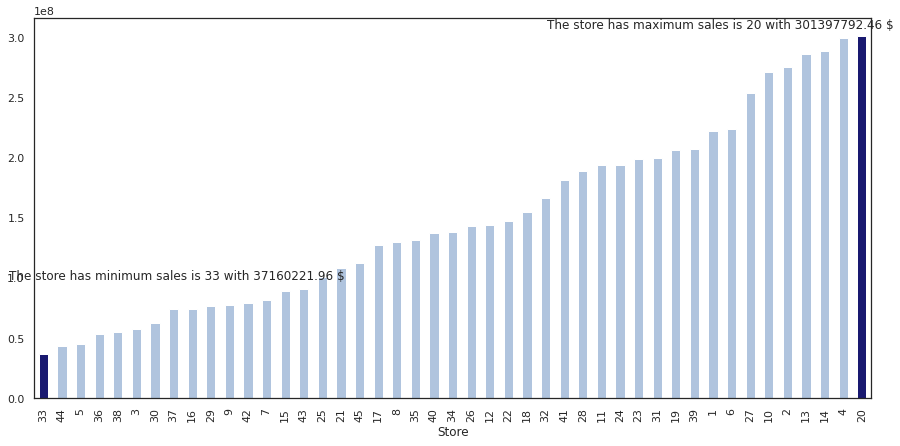

In [66]:
plt.figure(figsize=(15,7))

# Sum Weekly_Sales for each store, then sortded by total sales
total_sales_for_each_store = data.groupby('Store')['Weekly_Sales'].sum().sort_values() 
total_sales_for_each_store_array = np.array(total_sales_for_each_store) # convert to array

# Assigning a specific color for the stores have the lowest and highest sales
clrs = ['lightsteelblue' if ((x < max(total_sales_for_each_store_array)) and (x > min(total_sales_for_each_store_array))) else 'midnightblue' for x in total_sales_for_each_store_array]


ax = total_sales_for_each_store.plot(kind='bar',color=clrs);

# store have minimum sales
p = ax.patches[0]
print(type(p.get_height()))
ax.annotate("The store has minimum sales is 33 with {0:.2f} $".format((p.get_height())), xy=(p.get_x(), p.get_height()), xycoords='data',
            xytext=(0.17, 0.32), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            horizontalalignment='center', verticalalignment='center')


# store have maximum sales 
p = ax.patches[44]
ax.annotate("The store has maximum sales is 20 with {0:.2f} $".format((p.get_height())), xy=(p.get_x(), p.get_height()), xycoords='data',
            xytext=(0.82, 0.98), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            horizontalalignment='center', verticalalignment='center')


# plot properties
#plt.xticks(rotation=0)

Store 20 has maximum weekly sales

# **Do holidays have impact on sales? negative or positive?**

In [67]:
holiday_data = pd.DataFrame(data.groupby(['Holiday_Flag'])['Weekly_Sales'].mean())

In [68]:
holiday_data

,Weekly_Sales
Holiday_Flag,
0,1.041256e+06
1,1.122888e+06


Holidays have positive impact on sales

# **Draw scatter plot of monthly sales and provide your observations**

In [69]:
# Splitting Date and create new columns (Day, Month, and Year)
data["Day"]= pd.DatetimeIndex(data['Date']).day
data['Month'] = pd.DatetimeIndex(data['Date']).month
data['Year'] = pd.DatetimeIndex(data['Date']).year
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,quarter,Day,Month,Year
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,1,5,2,2010
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,1,12,2,2010
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,1,19,2,2010
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,1,26,2,2010
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,1,5,3,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,2012,9,3,28,9,2012
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,4,5,10,2012
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,4,12,10,2012
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,4,19,10,2012


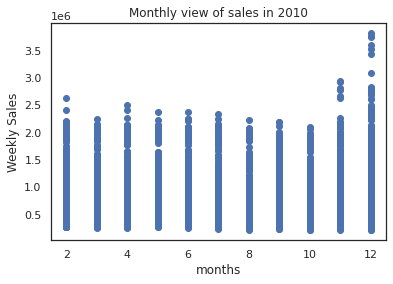

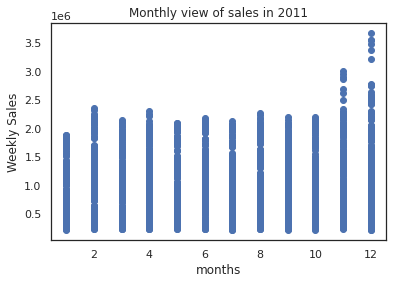

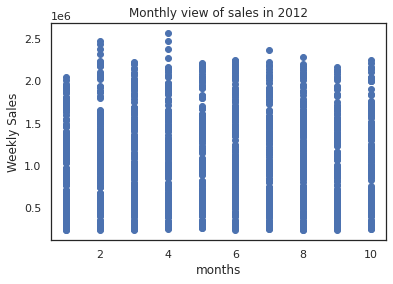

In [70]:
# Monthly view of sales for each years
plt.scatter(data[data.Year==2010]["Month"],data[data.Year==2010]["Weekly_Sales"])
plt.xlabel("months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2010")
plt.show()

plt.scatter(data[data.Year==2011]["Month"],data[data.Year==2011]["Weekly_Sales"])
plt.xlabel("months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2011")
plt.show()

plt.scatter(data[data.Year==2012]["Month"],data[data.Year==2012]["Weekly_Sales"])
plt.xlabel("months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2012")
plt.show()

## **Can you predict Weekly Sales using other columns, either with a Random Forest Algorithm or a Support Vector Machine?**

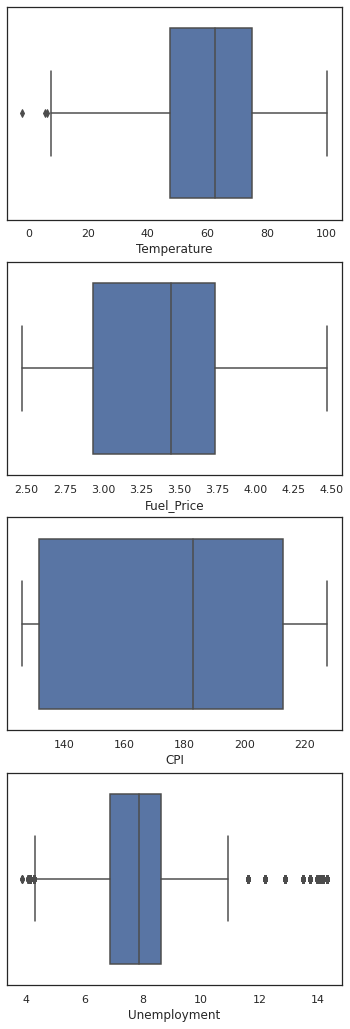

In [71]:
# find outliers 
fig, axs = plt.subplots(4,figsize=(6,18))
X = data[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(data[column], ax=axs[i])

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from sklearn.linear_model import LinearRegression

In [73]:
# Select features and target 
X = data[['Store','Fuel_Price','CPI','Unemployment','Day','Month','Year']]
y = data['Weekly_Sales']

# Split data to train and test (0.80:0.20)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

Random Forest Regressor:

Accuracy: 96.59023713813178
Mean Absolute Error: 57162.49022845135
Mean Squared Error: 11522909227.577967
Root Mean Squared Error: 107344.81462827147


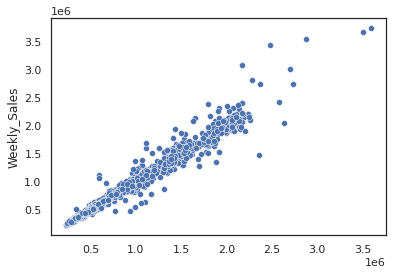

In [74]:
# Random Forest Regressor
print('Random Forest Regressor:')
print()
rfr = RandomForestRegressor(n_estimators = 400,max_depth=15,n_jobs=5)        
rfr.fit(X_train,y_train)
y_pred=rfr.predict(X_test)
print('Accuracy:',rfr.score(X_test, y_test)*100)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


sns.scatterplot(y_pred, y_test);

# **Sometimes predictions from other columns is challenging. In that case, model Weekly Sales column for years 2010 and 2011 with pymc3 and use that model to predict sales for every month in 2012. It's ok if your histogram is not exactly simgle-humped, as long as a single hump is a sufficiently good approximation.**

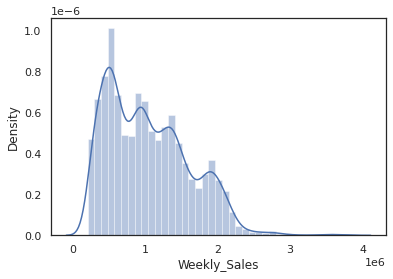

In [75]:
#plotting Weekly sales
sns.distplot(data['Weekly_Sales'])

**Building Bayesian Estimation Model using Pymc3**

In [76]:
data11 = data[["Weekly_Sales", "CPI", "Holiday_Flag", "Temperature"]]

In [77]:
from pymc3 import Model, Uniform,Normal

with Model() as data_model:
    μ = Uniform('μ', 0,0.8)
    σ = Uniform('σ', 0, 1)

In [78]:
with data_model:    
    p = Normal('p', mu=μ, sd=σ, observed=data11)

In [79]:
from pymc3 import Model, Uniform, Normal, Gamma

with Model() as sp:
    alpha = Uniform('alpha', 0, 10)
    beta = Uniform('beta', 0, 20)

In [80]:
with sp:  

    y = Gamma('y', alpha = alpha, beta = beta, observed=data11["Weekly_Sales"]) #likelihood

In [81]:
from pymc3 import fit
RANDOM_SEED = 20090425

with sp:

    samplesGamma1 = fit(random_seed=RANDOM_SEED).sample(500)

Finished [100%]: Average Loss = 7.6781e+09


In [82]:
alphas = samplesGamma1['alpha']
betas = samplesGamma1['beta']

In [83]:
SalesSample = Gamma.dist(alpha = alphas, beta = betas).random()

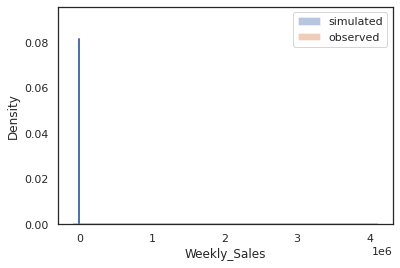

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(SalesSample, label='simulated')
sns.distplot(data11["Weekly_Sales"], label='observed')
plt.legend()

In [85]:
data10 = data.loc[data['Year'] == 2010].groupby('Month').sum('weekly_sales')
data10['Year'] = 2010
data10['Weekly_Sales']= data10['Weekly_Sales']/(10**8)
data10

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,quarter,Day,Year
Month,,,,,,,,,,,,
2,4140,1.903330,45,6531.84,484.554,30210.202610,1551.476,361800,360,180,2790,2010
3,4140,1.819198,0,8494.99,501.607,30227.552288,1551.476,361800,540,180,2790,2010
4,5175,2.314124,0,12802.81,645.421,37727.648220,1911.985,452250,900,450,3600,2010
5,4140,1.867109,0,11765.59,525.123,30175.516368,1529.588,361800,900,360,3150,2010
6,4140,1.922462,0,13513.78,501.841,30240.843812,1529.588,361800,1080,360,2610,2010
7,5175,2.325801,0,17853.19,624.149,37800.367400,1896.430,452250,1575,675,3600,2010
8,4140,1.876401,0,14205.55,500.940,30278.139478,1517.144,361800,1440,540,2970,2010
9,4140,1.772679,45,13104.24,492.213,30285.904384,1517.144,361800,1620,540,2430,2010
10,5175,2.171618,0,13986.43,631.638,37902.074930,1906.940,452250,2250,900,3375,2010


In [86]:
data011 = data.loc[data['Year'] == 2011].groupby('Month').sum('weekly_sales')
data011['Year'] = 2011
data011['Weekly_Sales']= data10['Weekly_Sales']/(10**8)
data011

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,quarter,Day,Year
Month,,,,,,,,,,,,
1,4140,NaN,0,6189.70,560.512,30382.527235,1492.416,361980,180,180,3150,2011
2,4140,1.903330e-08,45,6825.56,571.140,30526.206281,1492.416,361980,360,180,2610,2011
3,4140,1.819198e-08,0,8840.70,633.957,30658.299773,1492.416,361980,540,180,2610,2011
4,5175,2.314124e-08,0,12719.80,848.241,38475.181060,1833.780,452475,900,450,3375,2011
5,4140,1.867109e-08,0,11481.01,713.588,30847.859305,1467.024,361980,900,360,2970,2011
6,4140,1.922462e-08,0,13468.29,681.139,30820.821097,1467.024,361980,1080,360,2430,2011
7,5175,2.325801e-08,0,18092.92,830.075,38603.820411,1821.935,452475,1575,675,3375,2011
8,4140,1.876401e-08,0,14451.54,665.293,30941.069948,1457.548,361980,1440,540,2790,2011
9,5175,1.772679e-08,45,16436.14,820.340,38757.204172,1821.935,452475,2025,675,3600,2011


In [87]:
data12 = data.loc[data['Year'] == 2012].groupby('Month').sum('weekly_sales')
data12['Year'] = 2012
data12['Weekly_Sales']= data10['Weekly_Sales']/(10**8)
data12

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,quarter,Day,Year
Month,,,,,,,,,,,,
1,4140,NaN,0,7348.11,606.303,31368.178118,1351.500,362160,180,180,2970,2012
2,4140,1.903330e-08,45,7649.09,636.097,31431.302831,1351.500,362160,360,180,2430,2012
3,5175,1.819198e-08,0,11810.17,858.493,39406.847572,1689.375,452700,675,225,3600,2012
4,4140,2.314124e-08,0,10774.56,715.418,31589.395697,1335.516,362160,720,360,2970,2012
5,4140,1.867109e-08,0,12102.65,692.966,31610.778941,1335.516,362160,900,360,2610,2012
6,5175,1.922462e-08,0,17014.67,818.921,39510.849348,1669.395,452700,1350,450,3375,2012
7,4140,2.325801e-08,0,14292.63,630.912,31620.093064,1302.720,362160,1260,540,2970,2012
8,5175,1.876401e-08,0,17718.09,830.133,39549.392800,1628.400,452700,1800,675,3825,2012
9,4140,1.772679e-08,45,12823.03,695.569,31713.337811,1302.720,362160,1620,540,3150,2012


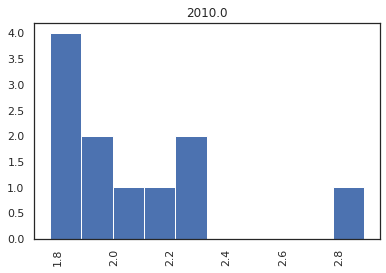

In [88]:
trial_data = pd.concat([data10, data11], ignore_index=True)
trial_data.hist('Weekly_Sales', by='Year')

**Predicting sales for 2012 using above defined model**

In [89]:
import pymc3 as pm
Y_pred = pm.sample_posterior_predictive(samplesGamma1, samples=1000, model=sp)

In [90]:
Y_pred_list = list(Y_pred.values())
Y_pred_list[0]

array([[ 5.32864279,  5.92135558,  9.07385803, ...,  7.28923738,
         9.26049819,  8.32128939],
       [11.6579516 , 13.46673188, 15.33026886, ..., 10.10968476,
         8.2689783 , 12.05555362],
       [16.95814865, 18.09832054, 15.53151937, ...,  7.8059381 ,
        15.70361111, 11.65717564],
       ...,
       [15.03279525, 13.6030482 ,  9.62439846, ..., 15.26572808,
        15.35343041, 10.59980024],
       [ 9.5376988 ,  7.93180214, 10.74660894, ..., 12.64984914,
         6.01831774,  9.20117051],
       [ 4.75371566,  4.72976139,  1.69527172, ...,  5.33931019,
         5.76270107,  4.2639435 ]])

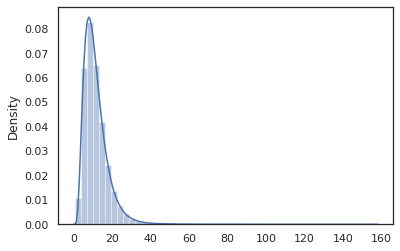

In [91]:
sns.distplot(Y_pred_list[0])

**----------------------------------------------------The End-----------------------------------------------**


